In [2]:
import warnings
warnings.filterwarnings('ignore') # warnings are for the weak

In [54]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import re
import sys

import fna

import pipeline as pipeline

sys.path.append("../demyelination/") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully read pickle files

In [4]:
def preparedf (dataobjs):
    # input dataframe
    # output organized data
    if len(dataobjs) == 0:
        raise Exception("No activity files found.")

    parts = dataobjs[0].spikeobj.keys()

    df = pd.DataFrame()

    for part in parts:
        for data in dataobjs:
            #data.spikeobj[part].time_offset(250)
            tmp = data.params
            tmp = tmp.update({
                "brainPart" : part,
                "meanSpkRate" : data.spikeobj[part].mean_rate(),
                "pearsonCoeff" : data.metrics['pearsoncoeff'][part],
                "cvIsi" : data.spikeobj[part].cv_isi().mean(),
                #"meanBurstSpikePercentageCerina" : np.mean(pipeline.computePopulationBurstSpikeRatio( data.spikeobj[part].time_slice(2000, 5000), "cerina" )),
                #"meanBurstSpikePercentageMIT" : np.mean(pipeline.computePopulationBurstSpikeRatio( data.spikeobj[part].time_slice(2000, 5000), "mit" )),
                #"meanBurstSpikePercentage" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part] ))
            })
            df = df.append(data.params, ignore_index=True)

    return df

In [5]:
def makesubplot (data, fig, ax, attr, varone, vartwo, brainParts, title="", unit=""):
    #varone, vartwo = "nuX_aone", "nuX_th"
    #for axis, part in zip([0, 1], ["MGN", "TRN"]):
    for axis, part in enumerate(brainParts):
        d = data[ data["brainPart"] == part ].pivot_table(attr, varone, vartwo)

        p = ax[axis].imshow(d, interpolation="nearest")
        
        cb = fig.colorbar(p, ax=ax[axis])
        cb.set_label(unit)

        ax[axis].set_title(title + " " + attr + " " + part)

        j = 2
        
        ax[axis].set_yticks(range(0, len(d.index.values), j))
        ax[axis].set_yticklabels(d.index.values[::j])
        
        ax[axis].set_xticks(range(0, len(d.columns.values), j))
        ax[axis].set_xticklabels(d.columns.values[::j])
        
        ax[axis].set_ylabel(varone)
        ax[axis].set_xlabel(vartwo)


In [57]:
def firingRatePlot (pth, f, mode="meanfiringrate"):
    p = pd.read_pickle(pth + f[0])
    fig, ax = plt.subplots(nrows=5, ncols=1)
    fig.set_size_inches(20, 24)

    for x in [0, 1, 2, 3]:
        ax[x].set_frame_on(False)
        ax[x].tick_params(labelbottom=False)
        ax[x].get_yaxis().set_ticks([])

    tstart = 1800
    tstop = 2300

    p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
    p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
    p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
    p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')
    
    colours = {'TRN' : 'lightblue', 'MGN' : 'pink', 'eA1' : 'brown', 'iA1' : 'orange'}

    for idx, brainPart in enumerate(['TRN', 'MGN', 'eA1', 'iA1']):
        if mode == 'meanfiringrate':
            ax[4].plot(p.spikeobj[brainPart].time_slice(tstart, tstop).firing_rate(10, average=True), label=brainPart, c=colours[brainPart])
            
        elif mode == 'kernelsmoothing':
            x, y = pipeline.smoothedspikes(p.spikeobj[brainPart].time_slice(tstart, tstop))
            ax[4].plot(x, y, label=brainPart, c=colours[brainPart])

    plt.xlabel("Time (ms)")
    plt.ylabel("Mean Spiking Rate")
    #plt.axhline(25, c='brown', label="y=25")

    #plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
    ax[2].spines.right.set_visible(False)
    ax[2].spines.top.set_visible(False)

    ax[4].legend()

In [5]:
tau = 10.

from fna.tools.signals import make_simple_kernel, pad_array
kernel = make_simple_kernel('exp', tau=tau, width=100., height=1./tau, resolution=1.)

def smoothedspikes(spikes):
    tau = 10
    #spikes = spikes.time_slice(0, l)

    kernel = make_simple_kernel('exp', tau=tau, width=100., height=1./tau, resolution=1.)
    axis_, rates = spikes.averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000)
    
    return axis_, rates

** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.


In [10]:
files2 = pipeline.readfiles("../demyelination/data/homo-gamma/activity/");
df = preparedf(files2);

MGN MEAN SPIKING RATE:  12.56 13.32 12.244
eA1 MEAN SPIKING RATE:  5.772666666666667 6.35 5.68775
eA1 PEARSON COEFF:  0.021786806159537844 0.03131392007160134 0.017790914434784325
MGN PEARSON COEFF:  0.033536419780659465 0.0627385380199391 0.035296724919155927


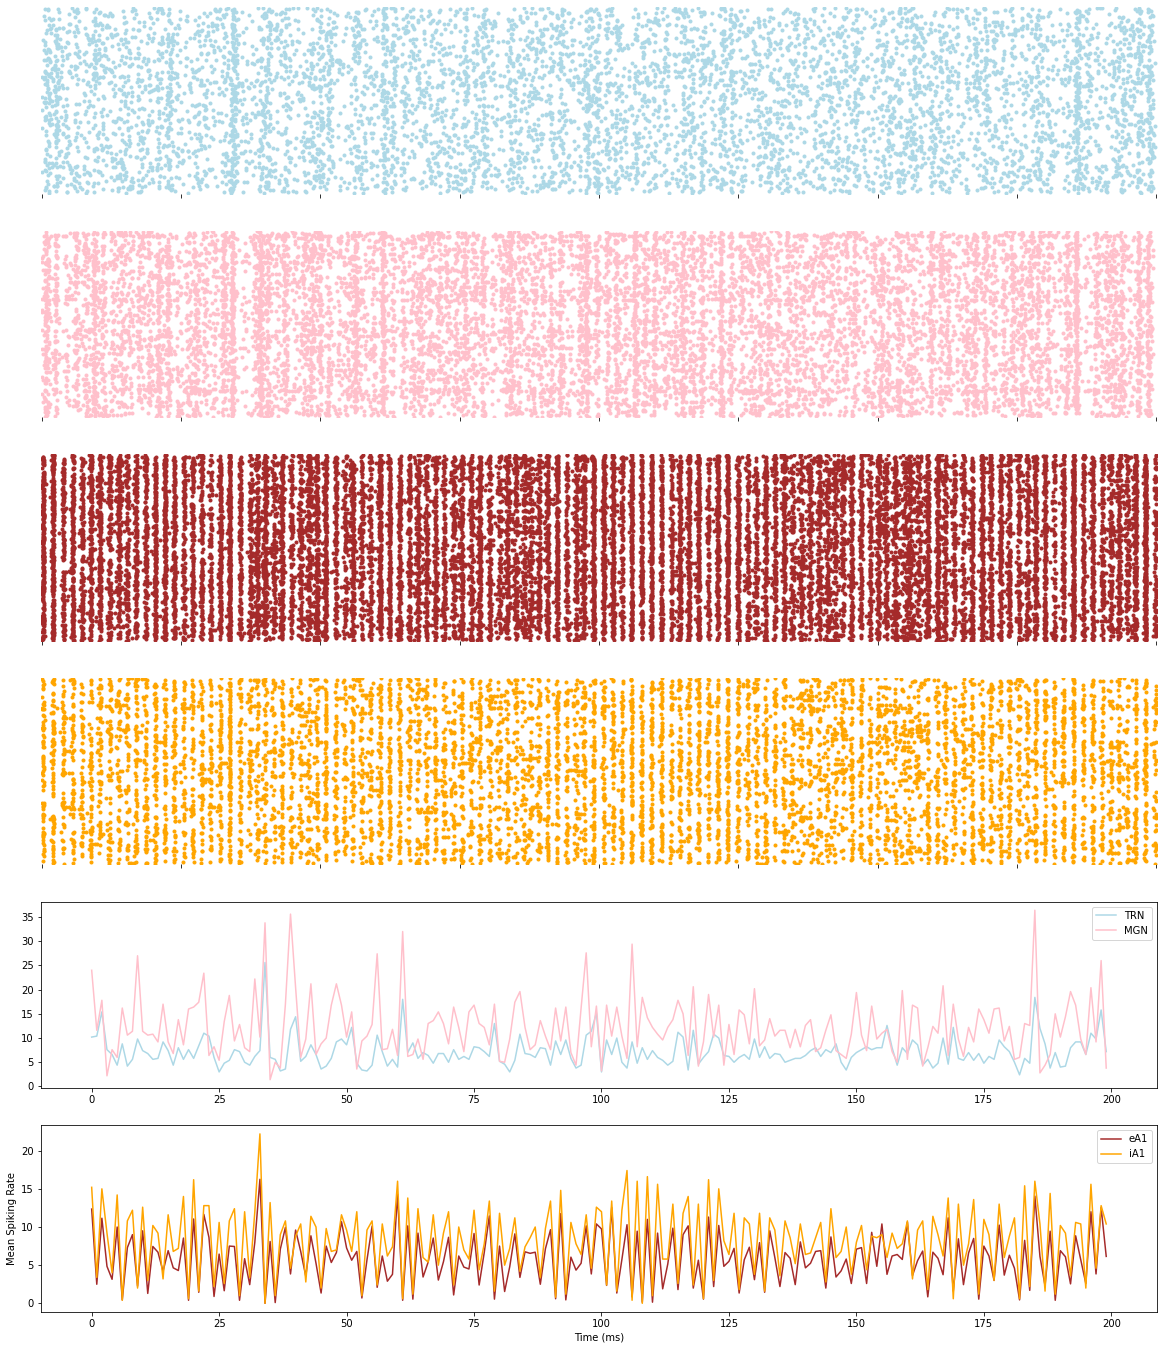

In [39]:
pth = "../demyelination/data/homo-gamma/activity/"
f = ['spk_homo-gamma_alpha=3.0_gamma_th=5.0_gamma_aone=5.0_nuX_th=14.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1000
tstop = 3000
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = pipeline.smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
# ax[5].plot(x, y, label='TRN', c='lightblue')
ax[4].plot(p.spikeobj['TRN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='TRN', c='lightblue')

x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
# ax[4].plot(x, y, label='MGN', c='pink')
ax[4].plot(p.spikeobj['MGN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='MGN', c='pink')

x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
# ax[5].plot(x, y, label='eA1', c='brown')
ax[5].plot(p.spikeobj['eA1'].time_slice(tstart, tstop).firing_rate(10, average=True), label='eA1', c='brown')

x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
# ax[5].plot(x, y, label='iA1', c='orange')
ax[5].plot(p.spikeobj['iA1'].time_slice(tstart, tstop).firing_rate(10, average=True), label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

In [62]:
np.unique(df.nuX_th)

array([ 4.,  7., 10., 14., 17., 20., 30., 35.])

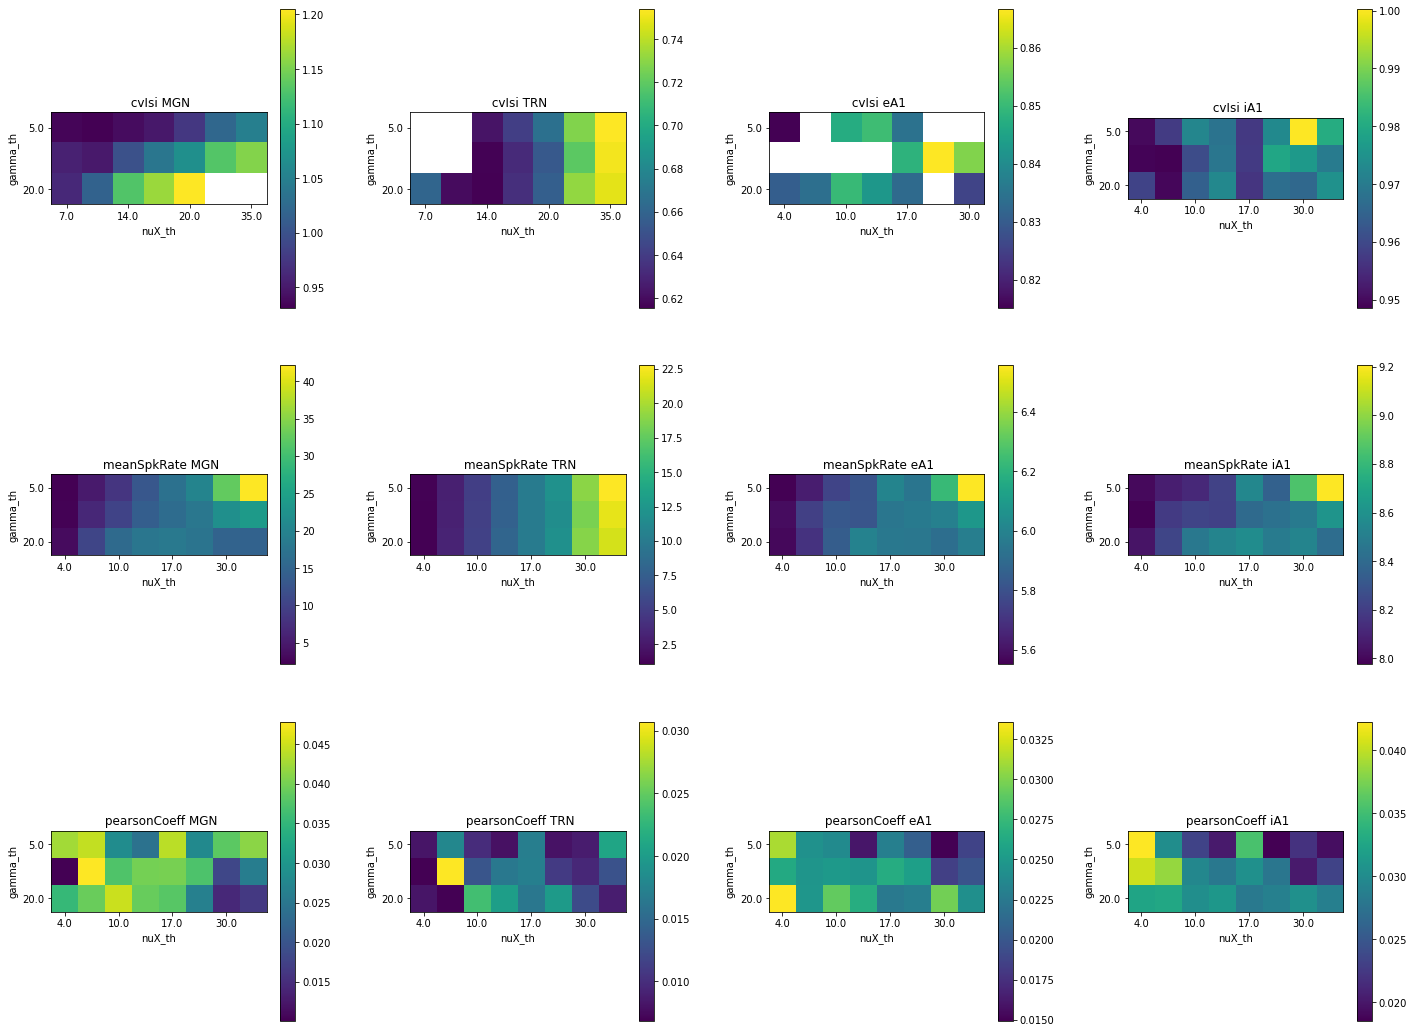

In [53]:
fig, ax = plt.subplots(nrows=3, ncols=4)

fig.set_size_inches(20, 15)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

dfFilter = (df.alpha == 3.) & (df.gamma_aone == 5.)
#(df.gamma_th == 10.0) & (df.gamma_aone == 10.) & (df.alpha > 0.) & (df.alpha < 10.) & (df.nuX_th < 17.)
# dfFilter = [True] * df.shape[0]

varone, vartwo = "gamma_th", "nuX_th"

makesubplot(df[dfFilter], fig, ax[0], "cvIsi", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

makesubplot(df[dfFilter], fig, ax[1], "meanSpkRate", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

makesubplot(df[dfFilter], fig, ax[2], "pearsonCoeff", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

# makesubplot(df[dfFilter], fig, ax[3], "meanBurstSpikePercentageCerina", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

# makesubplot(df[dfFilter], fig, ax[4], "meanBurstSpikePercentageMIT", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

fig.tight_layout()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/adaptation-aone_winputaone=15.pdf")

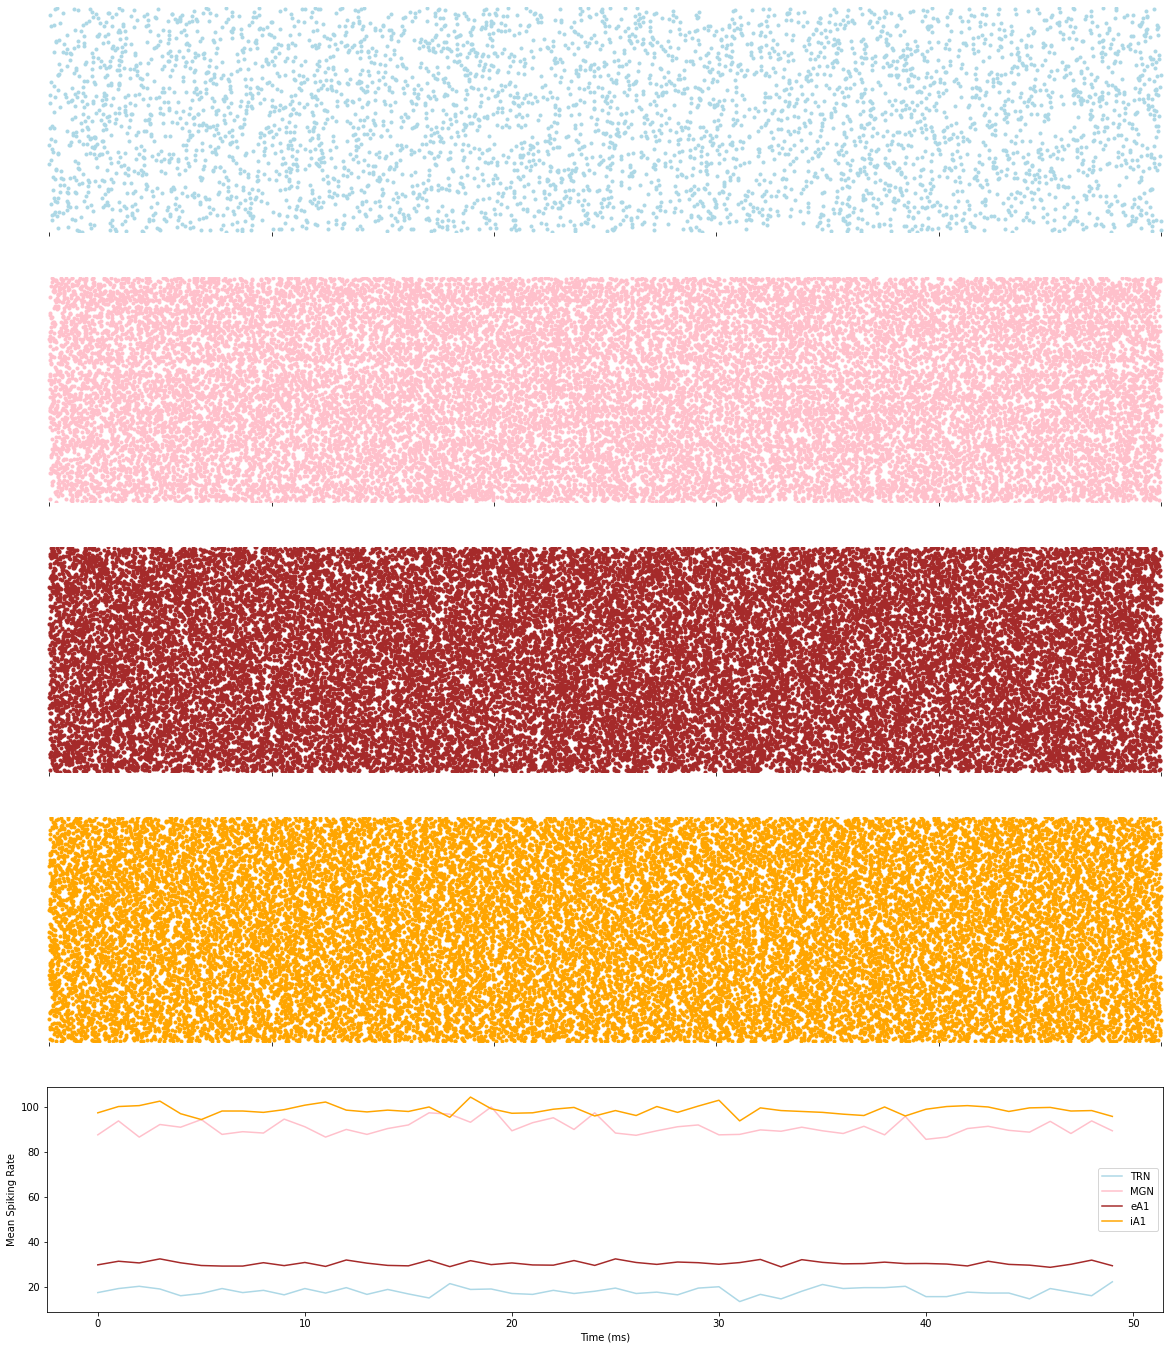

In [63]:
pth = "../demyelination/data/homo-gamma/activity/"
f = ['spk_homo-gamma_alpha=0.0_gamma_th=5.0_gamma_aone=5.0_nuX_th=35.0']
firingRatePlot(pth, f)

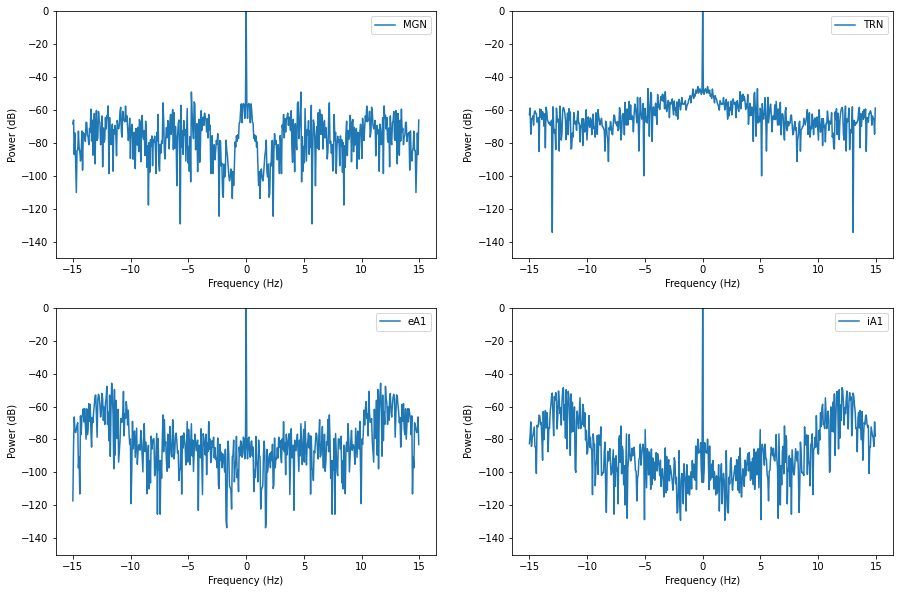

In [43]:
plotPowerSpectra(p)